In [1]:
import pandas as pd
import numpy as np
import numpy as np
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
#import actual and predicted prices
actual_prices = pd.read_csv('actual_prices_1.csv')
actual_prices['Date'] = pd.to_datetime(actual_prices['Date'])
actual_prices = actual_prices.set_index('Date')
predicted_prices = pd.read_csv('predicted_prices_1.csv')
predicted_prices['Date'] = pd.to_datetime(predicted_prices['Date'])
predicted_prices = predicted_prices.set_index('Date')

In [3]:
actual_prices.loc['2021':]

,AAPL,AMZN,BRK-B,GOOG,GOOGL,JNJ,MSFT,TSLA,UNH,XOM
Date,,,,,,,,,,
2021-01-04,128.087082,159.331497,228.449997,86.412003,86.306503,149.704880,214.479111,243.256668,341.344971,37.906910
2021-01-05,129.670700,160.925507,227.470001,87.045998,87.002502,151.465012,214.686005,245.036667,336.754639,39.733746
2021-01-06,125.305794,156.919006,230.270004,86.764503,86.143997,152.890320,209.119324,251.993332,350.886993,40.747643
2021-01-07,129.581650,158.108002,232.880005,89.362503,88.717003,153.406876,215.070251,272.013336,356.512634,41.067341
2021-01-08,130.700089,159.134995,234.029999,90.360497,89.891502,153.091202,216.380646,293.339996,354.910950,41.524048
...,...,...,...,...,...,...,...,...,...,...
2022-07-12,145.657669,109.220001,277.279999,114.849503,114.020500,174.676346,253.132690,233.070007,512.810913,83.686874
2022-07-13,145.288193,110.400002,277.470001,112.186996,111.353500,174.269089,252.184708,237.039993,499.672150,84.023605
2022-07-14,148.264053,110.629997,274.410004,111.440002,110.367500,174.507477,253.541840,238.313339,500.858429,82.339966


# MVT portfolio

Input:<br>
+ Mean vector: predicted returns on first day of the investment period (2021-01-04)
<br>
+ Covariance matrix: 20 days before the first day of the investment period 

Output:
<br>
+ Optimal weights for the portfolio, buy&hold the constructed portfolio until the end of the period (2022-07-18)

In [4]:
def port(mu, Q, tau):
    """
    This function return the optimal weights
    """
    n = len(mu)
    
    #matrix Gx <=h
    G = matrix(np.concatenate((-np.eye(n,n),np.eye(n,n)))) 
    h = matrix(np.concatenate((np.zeros(n),np.zeros(n)+0.5)))
    
    #matrix Ax = b
    A = matrix(np.ones(n)).T
    b = matrix([1.0])
    
    #get vector h that maximizes function U
    mu_temp = matrix(-tau*mu)
    sol = solvers.qp(Q,mu_temp,G,h,A,b)
    
    return sol['x']

In [5]:
#get actual and predicted return
pred_return = predicted_prices['2020-12-31':].pct_change().dropna()
act_return = actual_prices['2020-12-31':].pct_change().dropna()
#lookback returns used for covariance matrix
pred_return_cov = actual_prices.loc['2020-12-02':].pct_change().dropna()

In [6]:
pred_mu = matrix(pred_return.iloc[0])
lookback_var = matrix(pred_return_cov.iloc[0:20].cov().values)
    
    #optimal weights
h = port(pred_mu,lookback_var,0.5)
    #optimal daily returns
opt_return = np.array((matrix(act_return.dropna().values)*h))

     pcost       dcost       gap    pres   dres
 0: -4.6495e-03 -5.3467e+00  5e+00  3e-17  3e-16
 1: -4.8176e-03 -1.0629e-01  1e-01  1e-16  6e-16
 2: -1.1572e-02 -2.6724e-02  2e-02  2e-16  6e-17
 3: -1.6323e-02 -1.9176e-02  3e-03  1e-16  1e-17
 4: -1.7393e-02 -1.7631e-02  2e-04  2e-16  9e-18
 5: -1.7521e-02 -1.7524e-02  2e-06  3e-16  1e-17
 6: -1.7523e-02 -1.7523e-02  2e-08  2e-16  1e-17
Optimal solution found.


In [7]:
#Optimal weights
pd.DataFrame(h,index = act_return.columns, columns = ['weights']).T

,AAPL,AMZN,BRK-B,GOOG,GOOGL,JNJ,MSFT,TSLA,UNH,XOM
weights,0.000003,3.627269e-08,4.909913e-08,6.365406e-07,3.834161e-08,5.123996e-08,3.420264e-08,0.499999,4.375474e-08,0.499997


In [8]:
opt_return = pd.DataFrame(opt_return,index = pred_return.dropna().index,columns=['Return'])
opt_return

,Return
Date,
2021-01-04,0.020472
2021-01-05,0.027755
2021-01-06,0.026954
2021-01-07,0.043646
2021-01-08,0.044762
...,...
2022-07-12,-0.009373
2022-07-13,0.010529
2022-07-14,-0.007333


In [9]:
#cumulative return
opt_cum_return = np.cumprod(1+opt_return)-1

In [10]:
opt_cum_return

,Return
Date,
2021-01-04,0.020472
2021-01-05,0.048795
2021-01-06,0.077064
2021-01-07,0.124074
2021-01-08,0.174390
...,...
2022-07-12,0.615683
2022-07-13,0.632694
2022-07-14,0.620722


# Long-Only Strategy

For the prediction for each stock on the next day, if the prediction is positive, we buy the stock at the open price and sell the stock at close price in the same day. If the prediction is negative, no action is taken

In [27]:
#get open and close prices from 2021-01-04 to 2022-07-18
df = pd.read_csv('stockprices1.csv',index_col=0)
df['Date'] = pd.to_datetime(df.Date)
OpCl = df[['Date','Index','Open','Close']]
OpCl = OpCl.set_index(['Date','Index']).unstack(level=1).stack(level=0).unstack()['2021-01-04':'2022-07-18']
OpCl.head()

Index             AAPL                    AMZN                   BRK-B  \
                 Close        Open       Close        Open       Close   
Date                                                                     
2021-01-04  129.410004  133.520004  159.331497  163.500000  228.449997   
2021-01-05  131.009995  128.889999  160.925507  158.300507  227.470001   
2021-01-06  126.599998  127.720001  156.919006  157.324005  230.270004   
2021-01-07  130.919998  128.360001  158.108002  157.850006  232.880005   
2021-01-08  132.050003  132.429993  159.134995  159.000000  234.029999   

Index                        GOOG                 GOOGL             \
                  Open      Close       Open      Close       Open   
Date                                                                 
2021-01-04  231.729996  86.412003  87.876999  86.306503  88.000000   
2021-01-05  228.210007  87.045998  86.250000  87.002502  86.254501   
2021-01-06  229.490005  86.764503  85.131500  86.143997  85.013000   
2021-01-07  232.779999  89.362503  87.002998  88.717003  86.337997   
2021-01-08  233.539993  90.360497  89.399002  89.891502  88.858002   

Index              JNJ                    MSFT                    TSLA  \
                 Close        Open       Close        Open       Close   
Date                                                                     
2021-01-04  156.500000  157.240005  217.690002  222.529999  243.256668   
2021-01-05  158.339996  156.250000  217.899994  217.259995  245.036667   
2021-01-06  159.830002  157.240005  212.250000  212.169998  251.993332   
2021-01-07  160.369995  159.000000  218.289993  214.039993  272.013336   
2021-01-08  160.039993  160.509995  219.619995  218.679993  293.339996   

Index                          UNH                    XOM             
                  Open       Close        Open      Close       Open  
Date                                                                  
2021-01-04  239.820007  349.500000  351.450012  41.500000  41.450001  
2021-01-05  241.220001  344.799988  348.690002  43.500000  41.840000  
2021-01-06  252.830002  359.269989  337.109985  44.610001  44.410000  
2021-01-07  259.209991  365.029999  358.540009  44.959999  45.000000  
2021-01-08  285.333344  363.390015  367.000000  45.459999  45.200001

In [12]:
a = act_return.index
OpCl.loc[a[0],'AAPL'].Open

133.520004

In [13]:
tickers = act_return.columns
lo_return = []
for i in act_return.index:
    ret = []
    #get daily return = mean of stocks intraday returns
    for j in tickers:
        if pred_return.loc[i,j] > 0:
            ret.append((OpCl.loc[i,j].Close-OpCl.loc[i,j].Open)/OpCl.loc[i,j].Open)
            mu = np.mean(ret)
        
    lo_return.append(mu)

In [14]:
lo_return = pd.DataFrame(lo_return,index = pred_return.dropna().index,columns=['Return'])
lo_return

,Return
Date,
2021-01-04,-0.007029
2021-01-05,0.012092
2021-01-06,0.017664
2021-01-07,0.016878
2021-01-08,0.004433
...,...
2022-07-12,-0.018878
2022-07-13,0.001916
2022-07-14,0.009485


In [15]:
#cumulative return
lo_cum_return = np.cumprod(1+lo_return)-1
lo_cum_return

,Return
Date,
2021-01-04,-0.007029
2021-01-05,0.004978
2021-01-06,0.022730
2021-01-07,0.039992
2021-01-08,0.044602
...,...
2022-07-12,0.585065
2022-07-13,0.588103
2022-07-14,0.603166


# Benchmarks

### Equal weighted portfolio

In [16]:
#equal weighted
h_e = matrix(np.ones((10,1))*0.1)
#equal weighted daily returns
ew_return = np.array((matrix(act_return.dropna().values)*h_e))

In [17]:
ew_return = pd.DataFrame(ew_return,index = pred_return.dropna().index,columns=['Return'])
ew_return

,Return
Date,
2021-01-04,-0.007895
2021-01-05,0.008826
2021-01-06,0.002000
2021-01-07,0.024801
2021-01-08,0.013354
...,...
2022-07-12,-0.012753
2022-07-13,-0.004826
2022-07-14,-0.000952


In [18]:
#cumulative return
ew_cum_return = np.cumprod(1+ew_return)-1
ew_cum_return

,Return
Date,
2021-01-04,-0.007895
2021-01-05,0.000862
2021-01-06,0.002864
2021-01-07,0.027735
2021-01-08,0.041460
...,...
2022-07-12,0.268225
2022-07-13,0.262105
2022-07-14,0.260903


### S&P500

In [19]:
start = '2020-12-31'
end = '2022-07-19'

spy = yf.download('SPY',start,end)['Adj Close']
spy

[*********************100%***********************]  1 of 1 completed


Date
2020-12-31    364.738831
2021-01-04    359.773315
2021-01-05    362.251129
2021-01-06    364.416840
2021-01-07    369.831177
                 ...    
2022-07-12    379.272003
2022-07-13    377.280182
2022-07-14    376.363953
2022-07-15    383.554443
2022-07-18    380.387451
Name: Adj Close, Length: 388, dtype: float64

In [20]:
spy_return = spy.pct_change().dropna()

In [21]:
spy_cum_return = np.cumprod(1+spy.pct_change().dropna())-1
spy_cum_return

Date
2021-01-04   -0.013614
2021-01-05   -0.006821
2021-01-06   -0.000883
2021-01-07    0.013962
2021-01-08    0.019739
                ...   
2022-07-12    0.039845
2022-07-13    0.034384
2022-07-14    0.031872
2022-07-15    0.051587
2022-07-18    0.042904
Name: Adj Close, Length: 387, dtype: float64

# Portfolio Evaluation

Given $100, our graph shows how much our portfolio value increase compare to benchmarks

In [22]:
opt_equity = [100]
lo_equity = [100]
ew_equity = [100]
spy_equity = [100]
for i in range(0,len(opt_cum_return)):
    opt_equity.append(100*(1+opt_cum_return.iloc[i].values[0]))
    lo_equity.append(100*(1+lo_cum_return.iloc[i].values[0]))
    ew_equity.append(100*(1+ew_cum_return.iloc[i].values[0]))
    spy_equity.append(100*(1+spy_cum_return.iloc[i]))

In [23]:
timestamp = spy.index

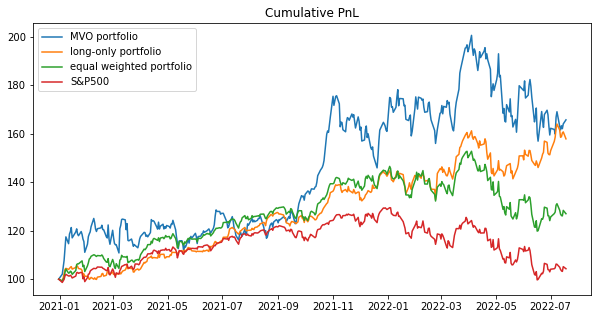

In [24]:
plt.figure(figsize = (10,5))
plt.plot(timestamp, opt_equity,label = 'MVO portfolio')
plt.plot(timestamp, lo_equity,label = 'long-only portfolio')
plt.plot(timestamp,ew_equity, label = 'equal weighted portfolio')
plt.plot(timestamp,spy_equity,label = 'S&P500')
plt.title('Cumulative PnL')
plt.legend(loc='best')
plt.show()

#### Annulized Sharpe Ratio

In [25]:
#MVT portfolio
opt_sharpe = opt_return.mean()/opt_return.std()*(252**0.5)
#Long-Only Strategy portfolio
lo_sharpe = lo_return.mean()/lo_return.std()*(252**0.5)
#equal weighted portfolio
ew_sharpe = ew_return.mean()/ew_return.std()*(252**0.5)
#SP500
spy_sharpe = spy_return.mean()/spy_return.std()*(252**0.5)

### Results

In [26]:
#a dataframe representing the final performence metrics of MVT portfolio & benchmarks
results = pd.DataFrame({'Cumulative Returns':[opt_cum_return.iloc[-1].values[0],
                                              lo_cum_return.iloc[-1].values[0],
                                              ew_cum_return.iloc[-1].values[0],
                                              spy_cum_return[-1]],
                        'Annualized Sharpe Ratio':[opt_sharpe.values[0],lo_sharpe.values[0],ew_sharpe.values[0],spy_sharpe]},
                      index = ['Mean Variance Optimal','Long-Only Strategy','Equal Weighted','SPY'])
results

,Cumulative Returns,Annualized Sharpe Ratio
Mean Variance Optimal,0.657104,1.100675
Long-Only Strategy,0.578738,1.801400
Equal Weighted,0.269856,0.857941
SPY,0.042904,0.242143
